In [1]:
import pandas as pd
import numpy as np
import os
import glob
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from ta import momentum, volatility, trend
import matplotlib.pyplot as plt
#info from https://data.binance.vision/?prefix=data/futures/um/monthly/klines/BTCUSDT/1d/ daily

In [2]:
# Check if tensorflow detects the GPU
from tensorflow.python.client import device_lib
def get_available_devices():
     local_device_protos = device_lib.list_local_devices()
     return [x.name for x in local_device_protos]
print(get_available_devices()) 

['/device:CPU:0', '/device:GPU:0']


In [3]:
# path of csvs
path = "input_daily/*.csv"

In [5]:
# Concatenate all the csv files into a DataFrame
def clean_csvs(path:str) -> pd.DataFrame():
    path = os.getcwd()
    csv_files = glob.glob(os.path.join(path, "input_daily/*.csv"))
    df_all = pd.DataFrame()
    for f in csv_files:
        df = pd.read_csv(f, names=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'], header=1)
        df_all = pd.concat([df,df_all])
    df_all = df_all.sort_values('Open time', ascending=True)
    df_all['date'] = pd.to_datetime(df_all['Open time'], unit='ms', origin='unix')
    df_all = df_all.set_index('date')
    df_all = pd.read_parquet("BTC_data_daily.parquet")
    return df_all

In [6]:
# Check if the parquet already exists, True load it, False run clean_csvs
if os.path.isfile("BTC_data_daily.parquet"):
    df_all = pd.read_parquet("BTC_data_daily.parquet")
else:
    df_all = clean_csvs(path)

In [7]:
# Select relevant features
price_features = ['Close', 'Volume']
indicator_features = ['rsi', 'macd', 'stoch', 'bbands']

# Calculate market indicators
df_all['rsi'] = momentum.RSIIndicator(df_all['Close'], window=14).rsi()
df_all['macd'] = trend.MACD(df_all['Close']).macd()
df_all['stoch'] = momentum.stoch(df_all['High'], df_all['Low'], df_all['Close'])
df_all['bbands'] = volatility.BollingerBands(df_all['Close']).bollinger_pband()

In [8]:
# We drop the NA data
df_all = df_all.dropna()

In [9]:
# Combine all features
all_features = price_features + indicator_features

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_all[all_features])

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [10]:
# Define the sequence length for input data
sequence_length = 10

# Create training sequences and targets
train_sequences = []
train_targets = []
for i in range(len(train_data) - sequence_length):
    train_sequences.append(train_data[i:i+sequence_length])
    train_targets.append(train_data[i+sequence_length])
train_sequences = np.array(train_sequences)
train_targets = np.array(train_targets)

In [21]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(sequence_length, len(all_features))))
model.add(Dense(len(all_features)))
model.compile(loss='mean_squared_error', optimizer='adam')

In [23]:
# Check if the model_weights file already exists, True load it, False run clean_csvs
if os.path.isfile("checkpoint_model_daily.h5"):
    model.load_weights('checkpoint_model_daily.h5')
else:
    # Train the model and save_weights
    model.fit(train_sequences, train_targets, epochs=50, batch_size=32, verbose=1)
    model.save_weights('checkpoint_model_daily.h5')

In [13]:
# Perform predictions on the test set
test_sequences = []
for i in range(len(test_data) - sequence_length):
    test_sequences.append(test_data[i:i+sequence_length])
test_sequences = np.array(test_sequences)
predictions = model.predict(test_sequences)

3/3 [==============================] - 0s 2ms/step


In [14]:
# Inverse transform the predictions and test data
predictions = scaler.inverse_transform(predictions)
test_data = scaler.inverse_transform(test_data[sequence_length:])

In [15]:
# Evaluate the model
mse = np.mean((predictions - test_data)**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(predictions - test_data))
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)

Root Mean Squared Error: 128826.14538673745
Mean Absolute Error: 37837.01689016723


In [16]:
scaler.inverse_transform(train_data)[:, 0]

array([37696.21, 38150.01, 37870.01, 38439.04, 37289.86, 41550.  ,
       41374.69, 42361.35, 43829.99, 44021.57, 44358.08, 43471.29,
       42366.  , 42199.87, 42041.13, 42525.14, 44529.6 , 43860.7 ,
       40491.7 , 39966.8 , 40052.6 , 38368.1 , 36986.4 , 38212.  ,
       37227.8 , 38315.1 , 39205.4 , 39099.3 , 37672.  , 43155.  ,
       42449.5 , 39127.7 , 39375.1 , 38401.1 , 37963.8 , 38709.9 ,
       41937.5 , 39407.2 , 38713.  , 38792.6 , 37743.7 , 39653.8 ,
       39271.  , 41105.8 , 40898.1 , 41751.5 , 42188.2 , 41261.  ,
       40982.  , 42349.8 , 42867.9 , 43973.4 , 44290.6 , 44489.2 ,
       46820.8 , 47121.9 , 47418.5 , 47053.2 , 45506.  , 45794.6 ,
       46392.4 , 46580.9 , 45477.4 , 43159.7 , 43417.1 , 42229.2 ,
       42727.7 , 42140.4 , 39505.6 , 40060.7 , 41129.8 , 39915.9 ,
       40529.5 , 40361.  , 39649.1 , 40785.6 , 41472.9 , 41327.7 ,
       40449.8 , 39674.2 , 39415.1 , 39433.4 , 40411.  , 38093.7 ,
       39732.5 , 38572.2 , 37614.5 , 37712.9 , 39684.  , 36534

In [17]:
pd.DataFrame([predictions[:, 0],test_data[:, 0]]).transpose().rename(columns={0:"prediction",1:"test_data"})

,prediction,test_data
0,21402.923828,24332.6
1,24207.333984,23526.6
2,23143.904297,24581.5
3,24196.482422,24636.9
4,24957.236328,24265.9
...,...,...
67,27737.509766,28395.9
68,27375.816406,29459.0
69,28713.431641,29300.0
70,29285.529297,29212.7


In [18]:
test_dates = df_all.index[train_size+10:]

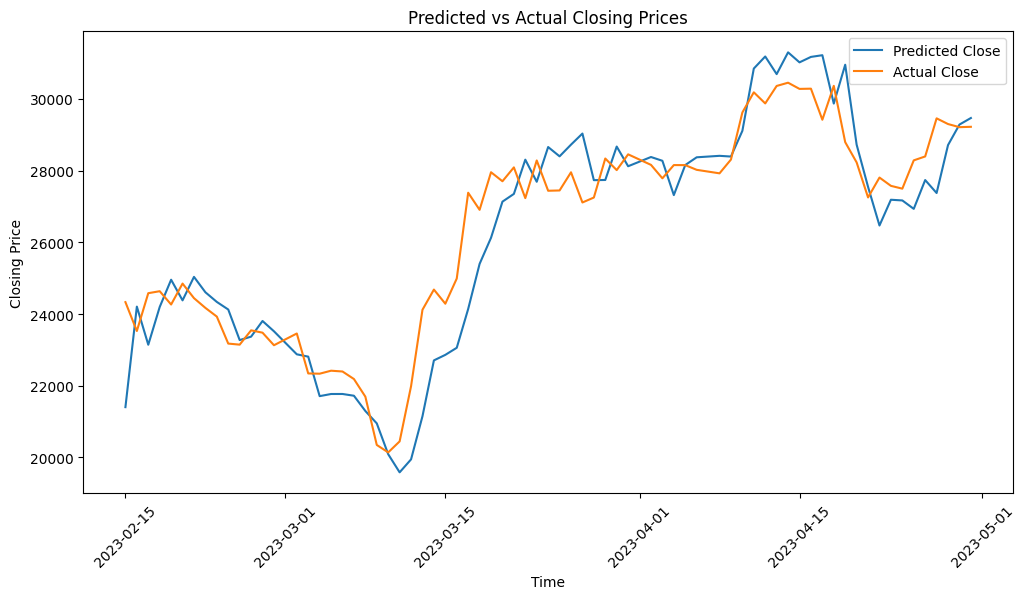

In [19]:
# Plot predicted and actual closing prices
plt.figure(figsize=(12, 6))
plt.plot(test_dates, predictions[:, 0], label='Predicted Close')
plt.plot(test_dates, test_data[:, 0], label='Actual Close')
plt.title('Predicted vs Actual Closing Prices')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

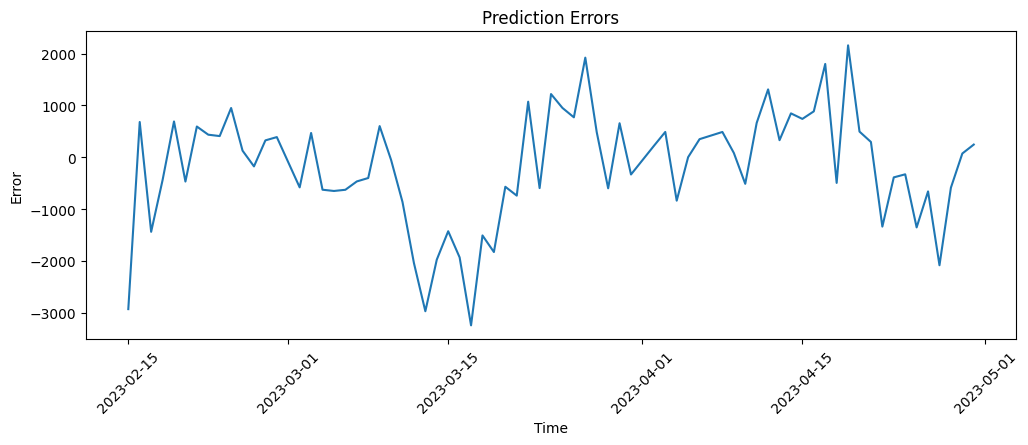

In [20]:
# Plot prediction errors
errors = predictions[:, 0] - test_data[:, 0]
plt.figure(figsize=(12, 4))
plt.plot(test_dates, errors)
plt.title('Prediction Errors')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.ylabel('Error')
plt.show()